# Create a Technology Type Column for FERC Steam Table

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard libraries
import logging
import sys
import os
import pathlib

# 3rd party libraries
import geopandas as gpd
import dask.dataframe as dd
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy as sa
#import pickle

# Local libraries
import pudl
from pudl.analysis.fill_ferc1_fuel_gaps import *

In [3]:
# Enable viewing of logging outputs
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

In [4]:
# Display settings
sns.set()
%matplotlib inline
mpl.rcParams['figure.dpi'] = 75
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [5]:
# Establish connection to pudl database
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
pudl_out = pudl.output.pudltabl.PudlTabl(
    pudl_engine=pudl_engine,
    freq='AS'
)

In [6]:
value_cols_no_cap = [
    'net_generation_mwh','avg_num_employees',
    'capex_land', 'capex_equipment', 'capex_structures', 'capex_total', 'asset_retirement_cost',
    'opex_operations', 'opex_fuel', 'opex_coolants', 'opex_steam', 'opex_steam_other', 'opex_transfer', 
    'opex_electric', 'opex_misc_power', 'opex_rents', 'opex_allowances', 'opex_engineering', 'opex_structures', 
    'opex_boiler', 'opex_plants', 'opex_misc_steam', 'opex_production_total'
]

value_cols = value_cols_no_cap + ['capacity_mw']

test_view = ['report_year', 'utility_name_ferc1', 'plant_name_ferc1', 'plant_id_pudl', 
             'plant_id_ferc1', 'primary_fuel', 'plant_type', 
             'tech_desc', 'tech_desc_flag','record_id', 'capacity_mw']

total_view = test_view + ['total_type']

ferc_merge_cols = ['report_year', 'utility_id_ferc1', 'plant_name_ferc1']
eia_merge_cols = ['report_date', 'plant_id_pudl', 'generator_id']

In [7]:
# with open('/Users/aesharpe/Desktop/ferc1_transformed2.pickle', 'rb') as handle:
#     ferc1_transformed_dfs_test = pickle.load(handle)

# with open('/Users/aesharpe/Desktop/steam_w_eia.pkl', 'rb') as handle:
#     steam_w_eia = pickle.load(handle)

In [7]:
# Establish table connections
steam = pudl_out.plants_steam_ferc1().assign(primary_fuel=np.nan)

fbp = pudl_out.fbp_ferc1()
fbp_small = fbp[ferc_merge_cols + ['primary_fuel_by_mmbtu']] #, 'primary_fuel_by_cost']]
eia = pudl_out.gens_eia860()#.assign(report_year=lambda x: x.report_date.dt.year)
small_plants = pudl_out.plants_small_ferc1()#.dropna(subset=['plant_name_ferc1'])
eia_one_plant = eia[eia['plant_name_eia'].notna()].drop_duplicates(subset='plant_name_eia').reset_index()
small_plants_one_plant = small_plants[small_plants['plant_name_ferc1'].notna()].drop_duplicates(subset='plant_name_ferc1').reset_index()

### Test Small Generators Table

In [10]:
from fuzzywuzzy import process, fuzz

In [11]:
plant_name_eia = []
similarity = []
for i in small_plants_one_plant.plant_name_ferc1:
        ratio = process.extract( i, eia_one_plant.plant_name_eia, limit=1)
        plant_name_eia.append(ratio[0][0])
        similarity.append(ratio[0][1])
small_plants_one_plant['plant_name_eia'] = pd.Series(plant_name_eia)
small_plants_one_plant['similarity'] = pd.Series(similarity)

### Run Module Code

In [201]:
# Add fuel type field to FERC
fuel_df = impute_fuel_type(steam, pudl_out)

filling fuels with obvious names
26511 / 28533 rows left unfilled
filling in primary fuel by mmbtu
3444 / 28533 rows left unfilled
filling in eia plants with one reported fuel
2211 / 28544 rows left unfilled
filling in primary fuel by cost
1958 / 28544 rows left unfilled
filling in raw ferc1 fuels
1806 / 28544 rows left unfilled
filling in ferc plants with one fuel
1069 / 28544 rows left unfilled
filling in pudl plants with one fuel
970 / 28544 rows left unfilled
filling in manually mapped fuels
885 / 28544 rows left unfilled
front and backfilling values with the same ferc1 id
660 / 28544 rows left unfilled
flipping single fuel outliers for plant_id_ferc1
660 / 28544 rows left unfilled
flipping multiple fuel outliers for groups under 7
660 / 28544 rows left unfilled


In [215]:
# Merge EIA technology description with FERC
tech_df = impute_tech_desc(fuel_df, eia)

merging single-tech EIA technology_description with FERC
25515 / 28544 rows left unfilled
backfilling EIA technology_description by year if no new units installed
15157 / 28544 rows left unfilled
filling fuels with obvious names
14489 / 28544 rows left unfilled
adding primary_fuel and plant_type columns
599 / 28544 rows left unfilled
making uniform tech description col


In [216]:
tech_df[test_view].tech_desc.unique()

array(['coal', 'gas_steam_turbine', 'nuclear', nan,
       'gas_combustion_turbine', 'petroleum_liquids',
       'gas_combined_cycle', 'gas_internal_combustion_engine', 'waste',
       'geothermal', 'hydroelectric_conventional', 'all_other', 'wind',
       'gas_unknown', 'solar'], dtype=object)

#### Notebook 2 module example

In [187]:
# Combine fuel type and plant type
tech_df['tech_fpt'] = tech_df['primary_fuel'] + '_' + tech_df['plant_type']

# Add new technology field to tech_desc and flag origin
flag = 'imputed fuel plus plant type'
tech_df = add_new_fuel_and_flag(tech_df, flag='temp', common_col='tech_desc', new_col='tech_fpt')
show_unfilled_rows(tech_df, 'tech_desc')

tech_df.loc[tech_df['tech_desc_flag']=='temp', 'tech_desc_flag'] = 'FPT ' + tech_df.primary_fuel_flag

599 / 28544


In [188]:
tech_df.groupby('tech_desc_flag').size()

tech_desc_flag
backfill from eia year                                  2185
backfill from other year                                8173
direct from eia860                                      3029
eia plant id has one fuel                                244
ferc plant id has one fuel                               478
ferc pudl map all                                        108
flipped lone fuel outlier in ferc1 id groups              75
flipped pockets of fuel outliers in ferc1 id groups      349
front and back filled based on ferc id                   194
manually filled in                                       119
obvious names                                            668
primary fuel by cost                                     164
primary fuel by mmbtu                                  12088
pudl plant id has one fuel                                71
dtype: int64

<AxesSubplot:>

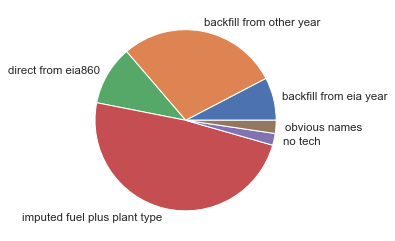

In [163]:
to_plot = tech_df.assign(tech_desc_flag=lambda x: x.tech_desc_flag.fillna('no tech'))
to_plot.groupby('tech_desc_flag').size().plot.pie(ylabel='')

In [172]:
# Rows that still don't have a technology type
tech_df.query("tech_desc.isna()")[test_view]

,report_year,utility_name_ferc1,plant_name_ferc1,plant_id_pudl,plant_id_ferc1,primary_fuel,plant_type,tech_desc,tech_desc_flag,record_id,capacity_mw
175,1994,ALABAMA POWER COMPANY,ala.elec. coop.,11539,8,NaN,unknown,NaN,NaN,f1_steam_1994_12_2_1_5,115.0
14170,1995,ALABAMA POWER COMPANY,ala. elec. coop.,11539,8,NaN,unknown,NaN,NaN,f1_steam_1995_12_2_2_5,0.0
14171,1996,ALABAMA POWER COMPANY,ala. elec. coop.,11539,8,NaN,unknown,NaN,NaN,f1_steam_1996_12_2_2_5,0.0
208,1994,ALABAMA POWER COMPANY,miss. power,8473,10,NaN,unknown,NaN,NaN,f1_steam_1994_12_2_2_5,0.0
209,1995,ALABAMA POWER COMPANY,miss. power,8473,10,NaN,unknown,NaN,NaN,f1_steam_1995_12_2_1_5,0.0
...,...,...,...,...,...,...,...,...,...,...,...
20574,2015,"Duke Energy Carolinas, LLC",buzzard roost,82,6190,NaN,combustion_turbine,NaN,NaN,f1_steam_2015_12_45_2_3,0.0
19453,2015,Georgia Power Company,intercession city,285,6197,NaN,combustion_turbine,NaN,NaN,f1_steam_2015_12_57_0_2,149.0
20575,2016,"Duke Energy Carolinas, LLC",buzzard roost,82,6347,NaN,combustion_turbine,NaN,NaN,f1_steam_2016_12_45_2_3,0.0
19454,2016,Georgia Power Company,intercession city,285,6362,NaN,combustion_turbine,NaN,NaN,f1_steam_2016_12_57_4_5,149.0


### Test accuracy of fuel + plant type

In [12]:
test2 = test2.assign(
    tech_desc=lambda x: x.tech_desc.replace({' ': '_'}, regex=True),
    primary_fuel=lambda x: x.primary_fuel.replace({'oil': 'petroleum'}, regex=True),
    similar_plant=np.nan,
    similar_fuel=np.nan
)

no_null_plant = test2['plant_type'].notna()
no_null_fuel = test2['primary_fuel'].notna()
no_null_tech = test2['tech_desc'].notna()

mini_plant = (
    test2[no_null_plant & no_null_tech].copy()
    .assign(similar_plant=lambda x: x.apply(lambda x: x.plant_type in x.tech_desc, axis=1))
)

mini_fuel = (
    test2[no_null_fuel & no_null_tech].copy()
    .assign(similar_fuel=lambda x: x.apply(lambda x: x.primary_fuel in x.tech_desc, axis=1))
)

test2.update(mini_plant, overwrite=True)
test2.update(mini_fuel, overwrite=True)

#test2.loc[(test2['similar_plant'].notna()) & (test2['similar_fuel'].notna()), 'similar'] =  
test2['similar'] = test2['similar_plant'] & test2['similar_fuel']

In [13]:
test3 = test2[no_null_plant & no_null_fuel & no_null_tech].copy()
print(len(test3))
print(len(test3[test3['similar']]))

13994
10942


In [14]:
n1 = test3['similar_fuel'] == False
n2 = test3['similar_plant'] == False

test3[n1 & n2][test_view].plant_id_pudl.astype('int').unique()

array([  242,  1283,   364,  2260,  2261,   283,    41,   554,   197,
         476,   647,  1136,  1158,    15,  1150,   549,  2628,   518,
         489,  5933, 14388, 13443,   122,  1526,     5,   472,  2134])

In [ ]:
# VIRGINIA and CON ED are problematic

# SUMMARY: some just need to be flipped, some are the wrong plant id, some are weird because there 
#          are sub-units that aren't reported in EIA, some are weird because they are waste energy,
#          some

# Problems:
# - 2133 ninemile - has a bad plant_id
# - 241 lee cc - should be coal pre 2012 but issues with ferc id and installation year... :/
# - 1282 Waterside - not a lot of information on what this is or when it stopped...
# - 275 hudson avenue - just need some gas fuels to get flipped
# - 363 JC McNeil - biomass, good
# - 2259 hunterstown - con-ed petro unclear...capacities don't match what I found online at alll
# - 2260 Mountain - another weird con-ed petro plant....no idea
# - 282 Huron - outliers must be flipped
# - 41 beebee - wrong plant id
# - 533 Sheepskin? - wrong plant id
# - 196 four corners - outliers must be flipped
# - 475 putnam - wrong plant id
# - 646 wilmarth - waste
# - 1537 south meadow - flip outliers
# - 648 wilson - flip outliers
# - 1135 grand tower energy center - wonkyness with backfill by year
# - 147 darbytown - flip outliers
# - 1157 Joppa - confusing subunits
# - 15 Altavista - went from coal to biomass in 2013
# - 1149 hopewell there is another hopewell in eia (3335) but the capacity from 1149 matches....:/
# - 548 southampton - went from coal to biomass in 2013
# - 45 bellmeade - some of it's right some not
# - 176 elizabeth river - plant type just wrong
# - 1132 gibson city - some weird outlier fuels and plant types
# - 2628 heart mountain / bird city wrong plant id
# - 517 rothschild - waste
# - 488 remington - some solar plants thrown in at the end! need to fix
# - 5930 - airport - seems that the primary fuel is right (rather than petro from eia)
# - 14385 river valley - MAYBE wrong plant id? unless they are co-located...
# - 13440 Okeechobee - MAYBE wrong plant id? unless they are co-located...
# - 121 coit - unknown valeus causing a problem
# - 1525 devon - flip outliers
# - 5 74th street - flip outliers
# - 471 parr gt - flip outliers

In [205]:
# Problems:
# - 2297 --> gap between ferc years and eia years so can't use the construction type col to see whether there was a new unit added or not...
#            Can use this as a backfill IF the operating_date from eia matches the closest one from FERC
# - 1656 --> False is the result of a NA in the construction_year field which should probably be ignored?

#ferc_eia_tech_desc[ferc_eia_tech_desc['plant_id_pudl']==190]

### Look at plants that still have more than one technology type

In [15]:
more_than_one_fuel = test2.groupby(['plant_id_pudl']).filter(lambda x: len(x.tech_desc.dropna().unique()) > 1)
len(more_than_one_fuel.plant_id_pudl.unique())
more_than_one_fuel.plant_id_pudl.unique()

array([650.,  57.])

In [75]:
plant_groups = more_than_one_fuel.groupby('plant_id_ferc1')
more_than_one_fuel[more_than_one_fuel['plant_id_ferc1']==57][test_view]

,report_year,utility_name_ferc1,plant_name_ferc1,plant_id_pudl,plant_id_ferc1,primary_fuel,plant_type,tech_desc,tech_desc_flag,record_id,capacity_mw


In [16]:
test2['tech_type'] = test2['primary_fuel'] + '_' + test2['plant_type']

In [26]:
# Look for ferc1 ids that have more than one fuel associated with them
more_than_one_fuel = test2.groupby(['plant_id_ferc1']).filter(lambda x: len(x.tech_type.dropna().unique()) > 1)
len(more_than_one_fuel.plant_id_ferc1.unique())
more_than_one_fuel.plant_id_ferc1.unique().astype('int')

array([   2,    3,    5,   15,   44,   59,   64,   65,   73,   74,   75,
         76,   77,   78,   79,   80,   91,  136,  142,  175,  189,  190,
        202,  209,  210,  214,  216,  223,  246,  247,  255,  295,  296,
        327,  329,  330,  347,  356,  359,  363,  365,  372,  397,  398,
        423,  478,  481,  507,  540,  553,  554,  565,  575,  576,  578,
        601,  632,  674,  681,  708,  711,  712,  713,  729,  747,  750,
        752,  845,  897,  901,  903,  904,  908,  911,  925,  934,  940,
        946,  947,  954,  958,  978, 1009, 1020, 1034, 1056, 1057, 1062,
       1078, 1092, 1093, 1094, 1098, 1099, 1104, 1107, 1129, 1139, 1157,
       1159, 1160, 1162, 1181, 1191, 1195, 1208, 1215, 1218, 1224, 1235,
       1294, 1318, 1332, 1342, 1355, 1356, 1456, 1479, 1484, 1494, 1503,
       1532, 1543, 1545, 1554, 1556, 1557, 1605, 1618, 1619, 1623, 1659,
       1712, 1723, 1828, 1886])

In [46]:
# Shows that of the plant_id_ferc1 values with more than one fuel over time, there are none that start
# and end with the same fuel type (meaning, hopefully, there are no pockets in the middle.)
more_than_one_fuel.sort_values(['report_year'])
same_first_last = more_than_one_fuel.groupby(['plant_id_ferc1'])['tech_type'].agg(lambda x: x.max==x.min)
more_than_one_fuel['same_first_last'] = more_than_one_fuel.plant_id_ferc1.map(same_first_last)
more_than_one_fuel[more_than_one_fuel['same_first_last']][test_view + ['same_first_last']].plant_id_ferc1.unique().astype('int')

array([], dtype=int64)

In [66]:
dd = test2[(test2['tech_type'].str.contains('coal')) & (test2['tech_type'].str.contains('steam')==False)][test_view + ['tech_type']]
len(dd.plant_id_pudl.astype('int').unique())

91

In [86]:
dd.query("plant_id_pudl==8005")
test2.query("plant_id_pudl==8005").utility_id_pudl.unique().item()
#test2.query("plant_name_ferc1.str.contains('deep')")[test_view]
test2.query("utility_id_pudl==33 and report_year>2005")

,report_year,utility_id_ferc1,utility_id_pudl,utility_name_ferc1,plant_id_pudl,plant_id_ferc1,plant_name_ferc1,asset_retirement_cost,avg_num_employees,capacity_factor,capacity_mw,capex_equipment,capex_land,capex_per_mw,capex_structures,capex_total,construction_type,construction_year,installation_year,net_generation_mwh,not_water_limited_capacity_mw,opex_allowances,opex_boiler,opex_coolants,opex_electric,opex_engineering,opex_fuel,opex_fuel_per_mwh,opex_misc_power,opex_misc_steam,opex_nonfuel,opex_nonfuel_per_mwh,opex_operations,opex_per_mwh,opex_plants,opex_production_total,opex_rents,opex_steam,opex_steam_other,opex_structures,opex_transfer,peak_demand_mw,plant_capability_mw,plant_hours_connected_while_generating,plant_type,record_id,water_limited_capacity_mw,primary_fuel,tech_desc,technology_description,dup,same_tech,tech_desc_flag,retired_unit,new_unit,backfill_by_year,backfill_by_eia_year,name_based,primary_fuel_flag,primary_fuel_by_mmbtu,primary_fuel_by_cost,fuel_type_code_pudl,fuel_type_code_pudl_ferc,fuel_avg_heat_raw,fuel_qty_burned,ferc1_id_has_one_fuel,pudl_id_has_one_fuel,fuel_type,fbfill,single_flip,multi_fuel_flip,similar_plant,similar_fuel,similar,tech_type
21637,2006.0,9.0,33.0,Atlantic City Electric Company,1080.0,33.0,bl england,60457000.0,107.0,0.316438,447.0,8925652.0,864584.0,157562.9,183372.0,70430608.0,conventional,1962.0,1974.0,1239081.0,447.0,5240822.0,8448051.0,NaN,1067255.0,5143782.0,47603966.0,38.418768,1860695.0,1223015.0,34103942.0,27.523578,5646064.0,65.9,3236728.0,81707908.0,NaN,1608978.0,NaN,628552.0,NaN,417.0,447.0,6032.0,steam,f1_steam_2006_12_9_0_5,447.0,coal,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,primary fuel by mmbtu,coal,coal,NaN,NaN,NaN,NaN,coal,coal,NaN,coal,NaN,coal,NaN,NaN,False,coal_steam
21638,2007.0,9.0,33.0,Atlantic City Electric Company,1080.0,33.0,bl england,NaN,107.0,0.036293,447.0,NaN,NaN,0.0,NaN,NaN,conventional,1962.0,1974.0,142115.0,447.0,-1018253.0,747565.0,NaN,3139.0,1159552.0,4806903.0,33.824037,125632.0,138832.0,619490.0,4.359075,-900619.0,38.2,235427.0,5426393.0,NaN,66387.0,NaN,61828.0,NaN,391.0,447.0,912.0,steam,f1_steam_2007_12_9_0_1,447.0,coal,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,primary fuel by mmbtu,coal,coal,NaN,NaN,NaN,NaN,coal,coal,NaN,coal,NaN,coal,NaN,NaN,False,coal_steam
23089,2006.0,9.0,33.0,Atlantic City Electric Company,1168.0,38.0,keystone (2.47%),NaN,168.0,0.012093,1872.0,NaN,NaN,0.0,NaN,NaN,outdoor,1967.0,1968.0,198308.0,1700.0,78163.0,274943.0,NaN,13552.0,33702.0,3701319.0,18.664497,181761.0,14436.0,1128084.0,5.688545,340113.0,24.4,79066.0,4829403.0,1691.0,58034.0,NaN,52623.0,NaN,1738.0,1700.0,5827.0,steam,f1_steam_2006_12_9_0_1,1700.0,coal,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,primary fuel by mmbtu,coal,coal,NaN,NaN,NaN,NaN,coal,NaN,NaN,coal,NaN,coal,NaN,NaN,False,coal_steam
24519,2006.0,9.0,33.0,Atlantic City Electric Company,1103.0,1110.0,conemaugh (3.83%),NaN,202.0,0.022411,1872.0,NaN,NaN,0.0,NaN,NaN,outdoor,1970.0,1970.0,367507.0,1700.0,605386.0,425722.0,NaN,61624.0,43099.0,6006405.0,16.343648,347790.0,19500.0,2450175.0,6.667016,561608.0,23.0,140924.0,8456580.0,1574.0,155333.0,NaN,87615.0,NaN,1722.0,1700.0,5831.0,steam,f1_steam_2006_12_9_0_3,1700.0,coal,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,primary fuel by mmbtu,coal,coal,NaN,NaN,NaN,NaN,coal,NaN,NaN,coal,NaN,coal,NaN,NaN,False,coal_steam
23090,2006.0,9.0,33.0,Atlantic City Electric Company,1168.0,1424.0,keystone (2.47%),NaN,NaN,0.000333,12.0,NaN,NaN,0.0,NaN,NaN,outdoor,1968.0,1968.0,35.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,171.0,internal_combustion,f1_steam_2006_12_9_0_2,12.0,coal,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,primary fuel by mmbtu,coal,coal,NaN,NaN,NaN,NaN,coal,NaN,NaN,coal,NaN,coal,NaN,NaN,False,coal_internal_combustion
24520,2006.0,9.0,33.0,Atlantic City Electric Company,1103.0,1425.0,conemaugh (3.83%),NaN,NaN,0.000105,12.0,NaN,NaN,0.0,NaN,NaN,outdoor,1970.0,1970.0,11.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN

,report_year,utility_name_ferc1,plant_name_ferc1,plant_id_pudl,plant_id_ferc1,primary_fuel,plant_type,tech_desc,tech_desc_flag,record_id,capacity_mw
436,1994.0,Atlantic City Electric Company,deepwater,8005.0,34.0,coal,steam,NaN,NaN,f1_steam_1994_12_9_0_2,250.10
438,1995.0,Atlantic City Electric Company,deepwater,8005.0,34.0,coal,steam,NaN,NaN,f1_steam_1995_12_9_0_2,250.10
440,1996.0,Atlantic City Electric Company,deepwater,8005.0,34.0,coal,steam,NaN,NaN,f1_steam_1996_12_9_0_2,240.90
442,1997.0,Atlantic City Electric Company,deepwater,8005.0,34.0,coal,steam,NaN,NaN,f1_steam_1997_12_9_0_2,240.90
444,1998.0,Atlantic City Electric Company,deepwater,8005.0,34.0,coal,steam,NaN,NaN,f1_steam_1998_12_9_0_2,216.20
446,1999.0,Atlantic City Electric Company,deepwater,8005.0,34.0,coal,steam,NaN,NaN,f1_steam_1999_12_9_0_2,216.20
448,2000.0,Atlantic City Electric Company,deepwater,8005.0,34.0,coal,steam,NaN,NaN,f1_steam_2000_12_9_0_2,216.20
450,2001.0,Atlantic City Electric Company,deepwater,8005.0,34.0,coal,steam,NaN,NaN,f1_steam_2001_12_9_0_1,216.00
452,2002.0,Atlantic City Electric Company,deepwater,8005.0,34.0,coal,steam,NaN,NaN,f1_steam_2002_12_9_0_1,216.00
454,2003.0,Atlantic City Electric Company,deepwater,8005.0,34.0,coal,steam,NaN,NaN,f1_steam_2003_12_9_0_1,216.00
